Python实验报告三 Task1

In [ ]:
!pip install surprise

In [1]:
# 1. 彻底卸载所有可能的冲突库
!pip uninstall -y numpy numba tensorflow scikit-surprise surprise jax jaxlib pymc blosc2 thinc treescope dopamine-rl cudf-cu12 dask-cuda librosa umap-learn pynndescent stumpy shap tensorflow-decision-forests

# 2. 尝试安装 numpy 1.26.4
#    这个版本在 Python 3.11 上应该有轮子，并且是 1.x 系列的最新。
!pip install numpy==1.26.4

# 3. 立即安装 surprise
#    scikit-surprise 1.1.4 依赖 numpy >= 1.19.5，所以 1.26.4 应该满足其要求。
!pip install surprise

Found existing installation: numpy 1.24.4
Uninstalling numpy-1.24.4:
  Successfully uninstalled numpy-1.24.4
Found existing installation: jax 0.5.2
Uninstalling jax-0.5.2:
  Successfully uninstalled jax-0.5.2
Found existing installation: jaxlib 0.5.1
Uninstalling jaxlib-0.5.1:
  Successfully uninstalled jaxlib-0.5.1
Found existing installation: pymc 5.22.0
Uninstalling pymc-5.22.0:
  Successfully uninstalled pymc-5.22.0
Found existing installation: blosc2 3.3.3
Uninstalling blosc2-3.3.3:
  Successfully uninstalled blosc2-3.3.3
Found existing installation: thinc 8.3.6
Uninstalling thinc-8.3.6:
  Successfully uninstalled thinc-8.3.6
Found existing installation: treescope 0.1.9
Uninstalling treescope-0.1.9:
  Successfully uninstalled treescope-0.1.9
Found existing installation: dopamine_rl 4.1.2
Uninstalling dopamine_rl-4.1.2:
  Successfully uninstalled dopamine_rl-4.1.2
Found existing installation: cudf-cu12 25.2.1
Uninstalling cudf-cu12-25.2.1:
  Successfully uninstalled cudf-cu12-25.2.

数据加载成功，原始形状: (148670, 34)
原始数据中 'Status' 列的唯一值及其计数:
Status
0    112031
1     36639
Name: count, dtype: int64
--------------------------------------------------

------- 数据探索性分析 (EDA) 可视化 -------


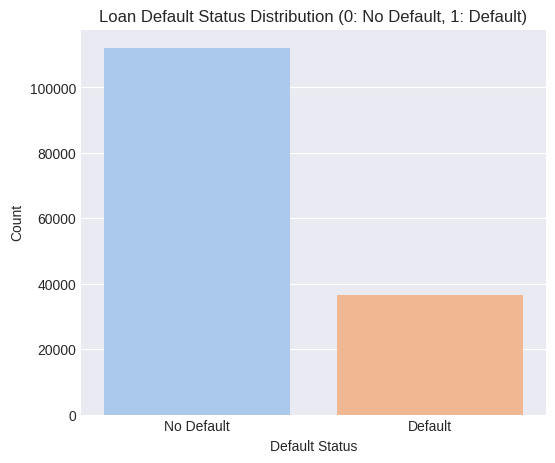

已显示目标变量 'Status' 的分布。


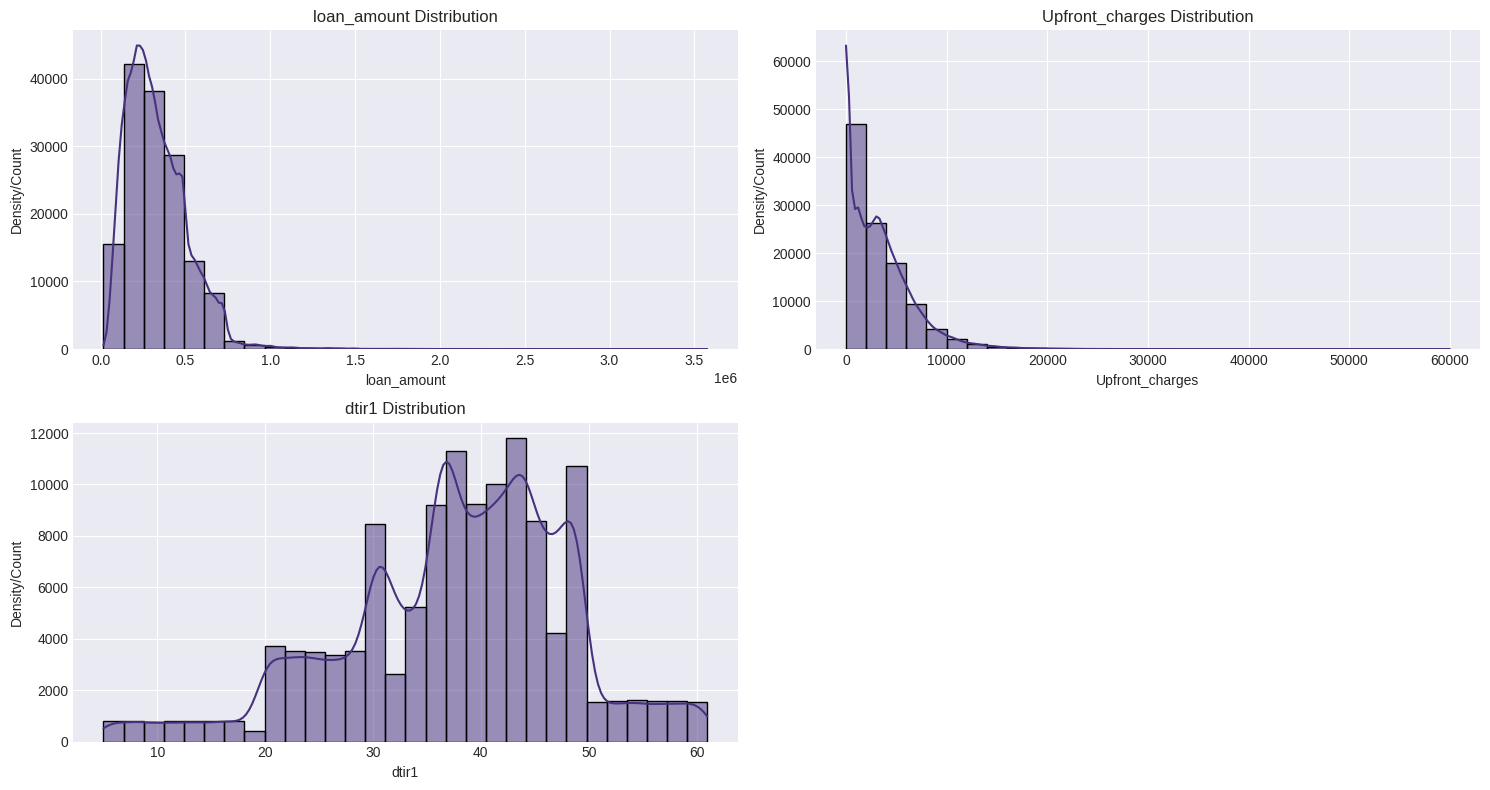

已显示部分数值特征的分布 (loan_amount, Upfront_charges, dtir1)。


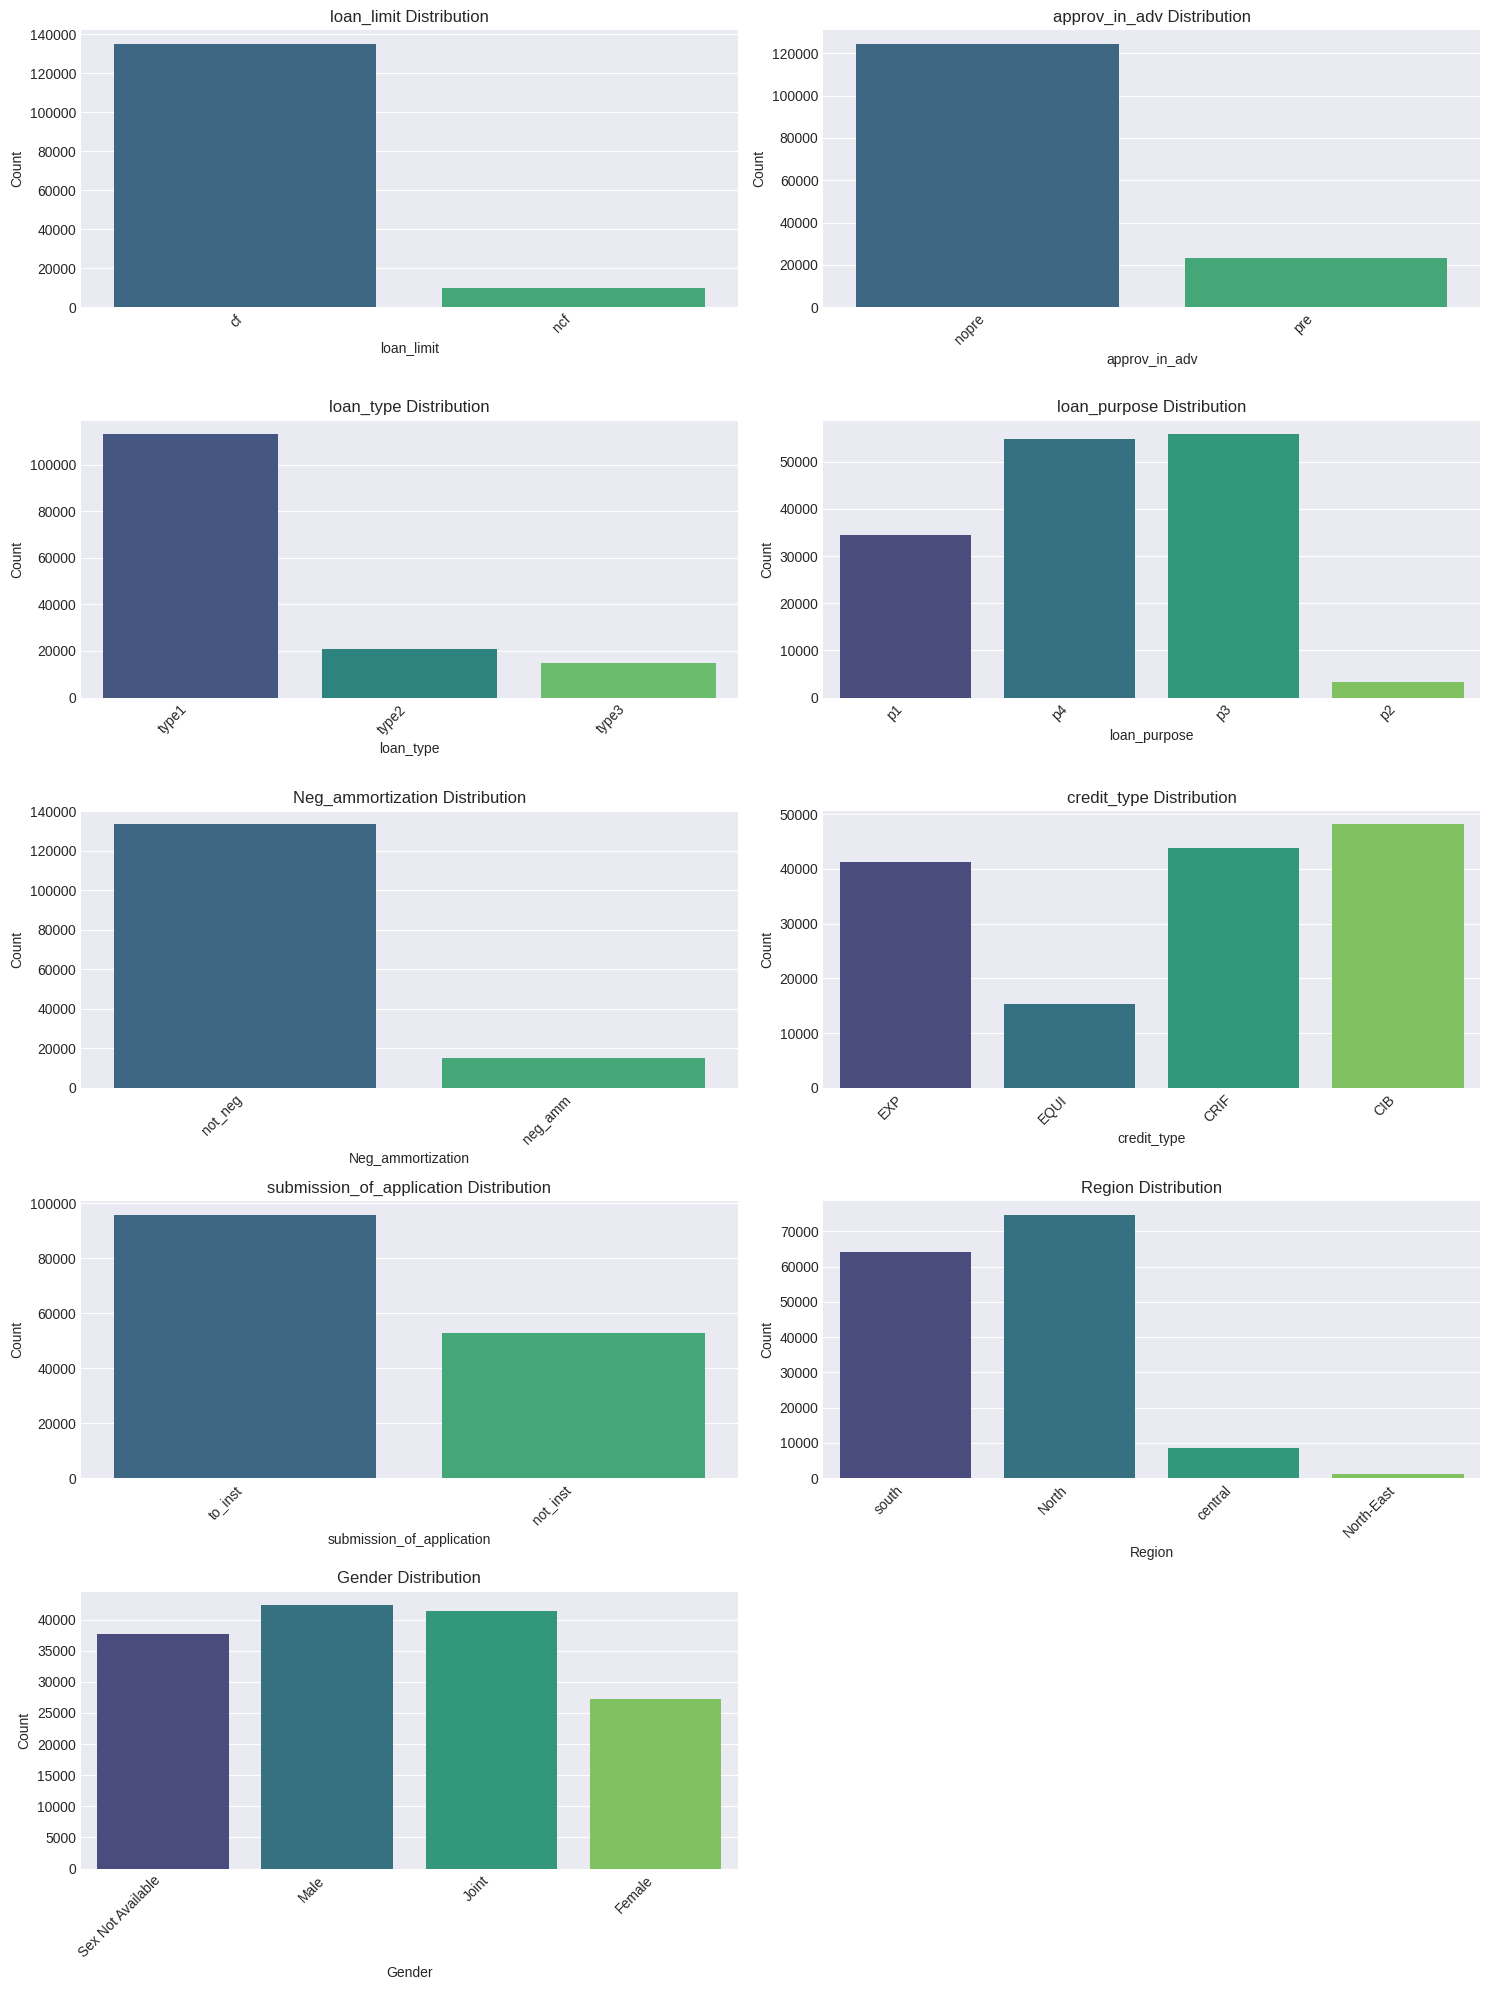

已显示部分编码后类别特征的分布 (loan_limit, approv_in_adv, loan_type, loan_purpose, Neg_ammortization, credit_type, submission_of_application, Region, Gender)。


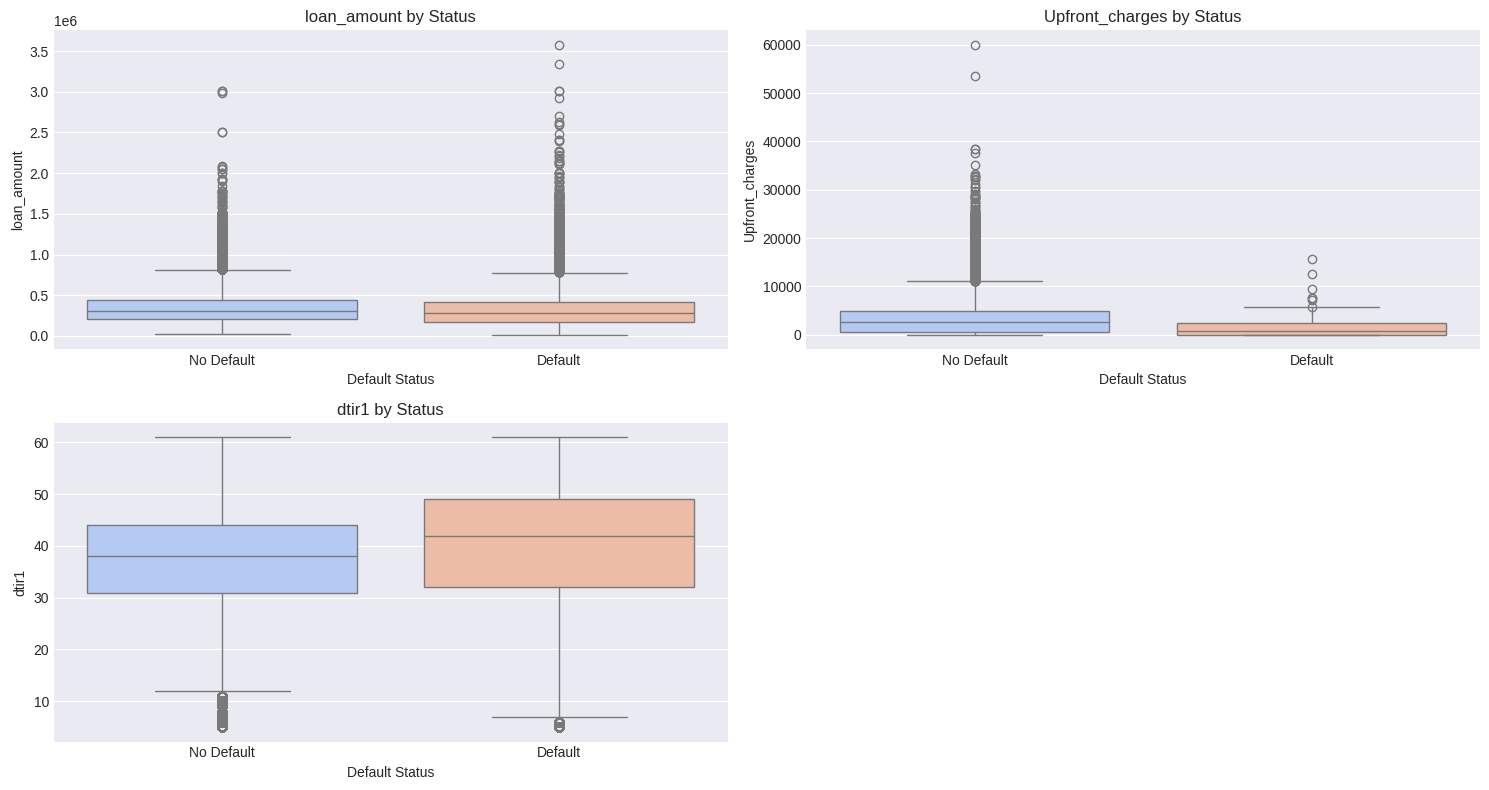

已显示部分数值特征与 'Status' 的关系。


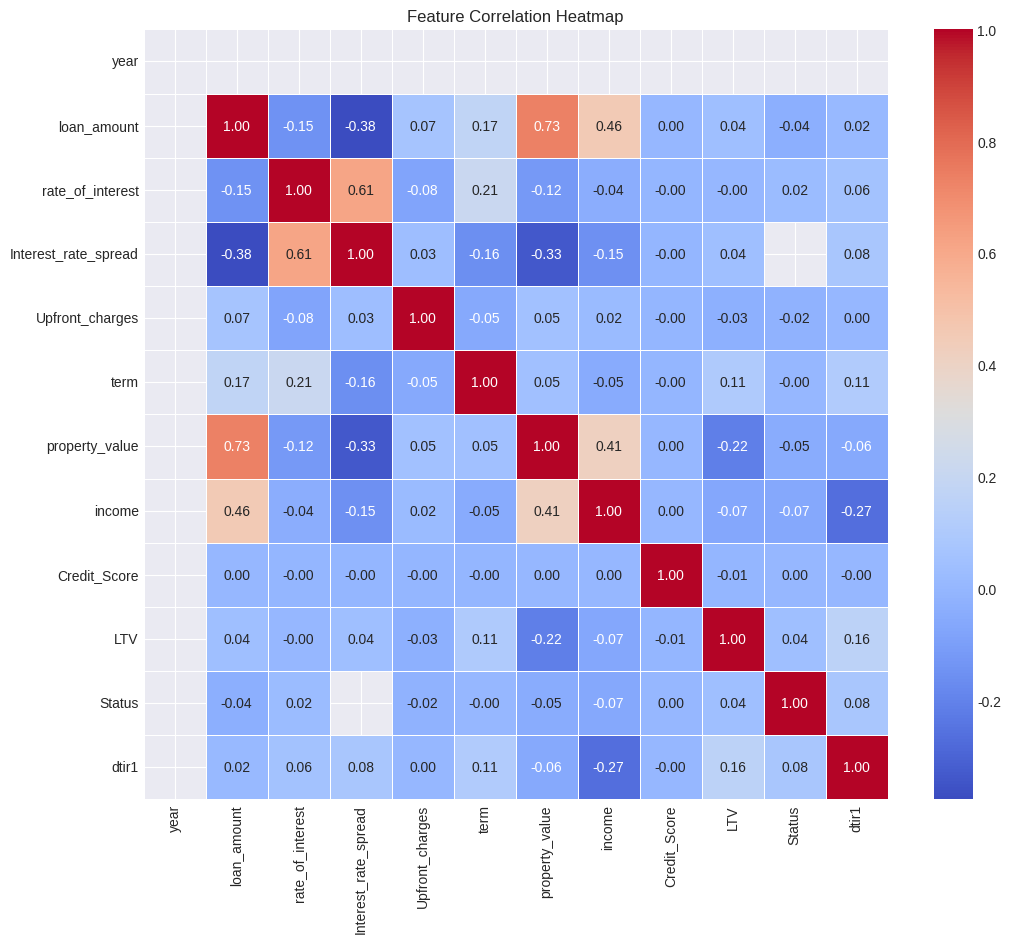

已显示特征相关性热力图。
--------------------------------------------------
------- 进入数据预处理函数 -------
开始填充缺失值...
处理缺失值后，行数保持不变: 148670 行。
在填充缺失值之后，'Status' 列的分布:
Status
0    112031
1     36639
Name: count, dtype: int64
--------------------------------------------------
处理重复值后，删除 0 行，剩余 148670 行。
在 drop_duplicates 之后，'Status' 列的分布:
Status
0    112031
1     36639
Name: count, dtype: int64
--------------------------------------------------
已删除 'ID' 列。
--------------------------------------------------
数据预处理完成。
所有预处理完成后，数据形状: (148670, 33)，'Status' 列的最终分布:
Status
0    112031
1     36639
Name: count, dtype: int64
--------------------------------------------------
已移除可能导致数据泄露的特征: ['rate_of_interest', 'Interest_rate_spread', 'Upfront_charges']

------- 训练集和测试集标准化 (避免数据泄露) -------
数值特征 ['loan_limit', 'Gender', 'approv_in_adv', 'loan_type', 'loan_purpose', 'Credit_Worthiness', 'open_credit', 'business_or_commercial', 'loan_amount', 'term', 'Neg_ammortization', 'interest_only', 'lump_sum_payment', 'property_

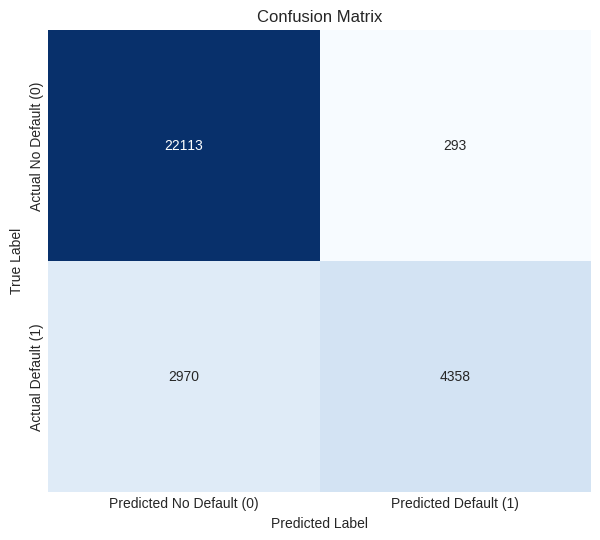

已显示混淆矩阵。


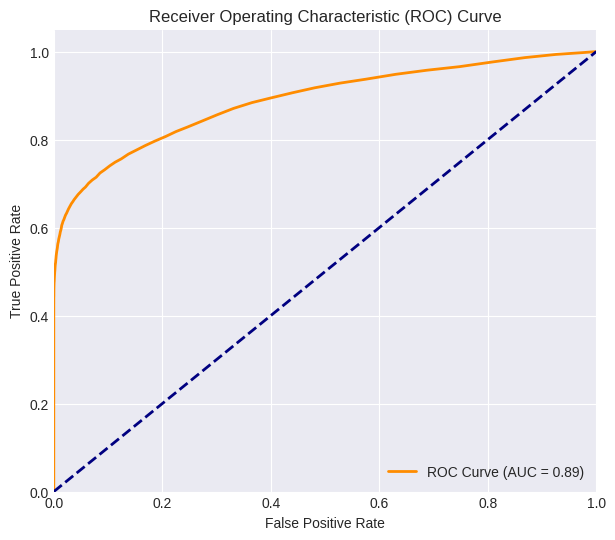

已显示 ROC 曲线。


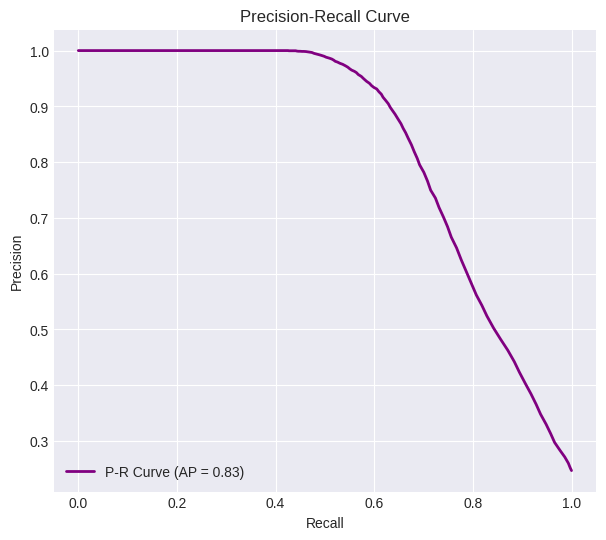

已显示精确率-召回率曲线。
--------------------------------------------------

------- 特征重要性可视化 -------


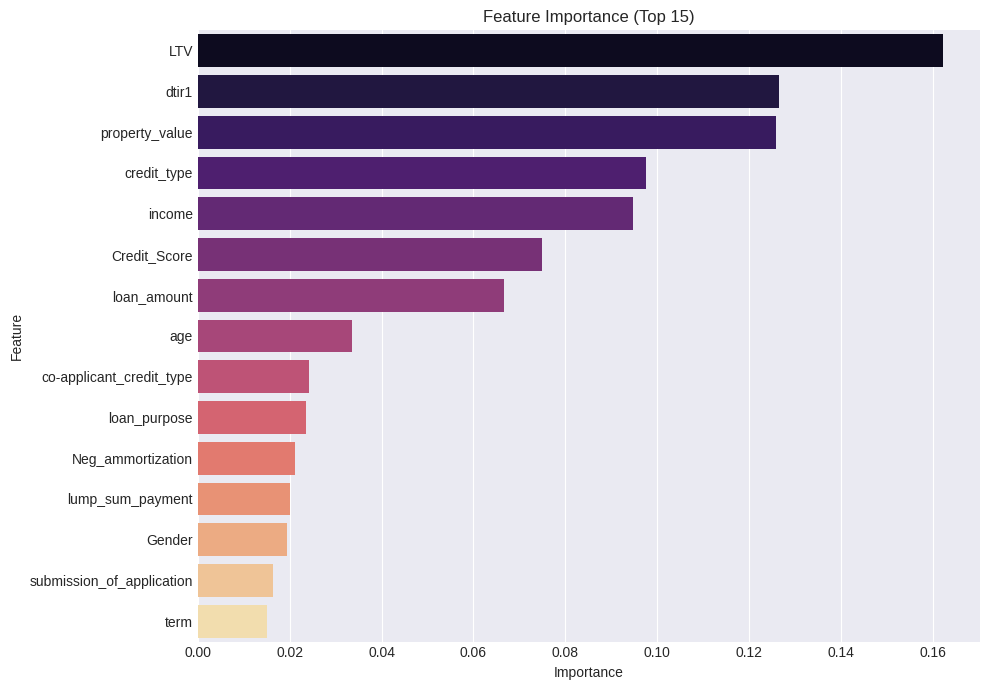

已显示前 15 个重要特征的条形图。
--------------------------------------------------


In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, classification_report, confusion_matrix,
    roc_curve, precision_recall_curve, average_precision_score
)
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore') # 忽略警告信息

# --- Plotting style settings ---
# Reverted to English for plot titles/labels, so no Chinese font settings needed here.
try:
    plt.style.use('seaborn-v0_8-darkgrid')
except:
    plt.style.use('seaborn-darkgrid')

sns.set_palette('viridis') # 设置默认调色板
# --- End plotting style settings ---


# --- 数据加载和预处理 ---

def load_data(filepath):
    """加载数据集"""
    df = pd.read_csv(filepath)
    print(f"数据加载成功，原始形状: {df.shape}")
    print(f"原始数据中 'Status' 列的唯一值及其计数:\n{df['Status'].value_counts()}")
    print("-" * 50)
    return df

def preprocess_data(df):
    """数据预处理，包括缺失值处理、编码和标准化"""
    print("------- 进入数据预处理函数 -------")
    # 1. 缺失值处理：使用填充（中位数/众数）而不是删除行
    print("开始填充缺失值...")

    # 填充数值型列的缺失值（使用中位数）
    for col in df.select_dtypes(include=np.number).columns:
        if col != 'Status': # 不填充目标变量
            if df[col].isnull().any(): # 检查该列是否有缺失值
                median_val = df[col].median()
                df[col].fillna(median_val, inplace=True)

    # 填充对象（类别）型列的缺失值（使用众数）
    for col in df.select_dtypes(include='object').columns:
        if df[col].isnull().any(): # 检查该列是否有缺失值
            mode_val = df[col].mode()[0] # mode() 返回 Series，取第一个值
            df[col].fillna(mode_val, inplace=True)

    print(f"处理缺失值后，行数保持不变: {df.shape[0]} 行。")
    print(f"在填充缺失值之后，'Status' 列的分布:\n{df['Status'].value_counts()}")
    print("-" * 50)

    # 2. 重复值处理：删除完全重复的行
    initial_rows_before_duplicates = df.shape[0]
    df.drop_duplicates(inplace=True)
    rows_dropped_by_duplicates = initial_rows_before_duplicates - df.shape[0]
    print(f"处理重复值后，删除 {rows_dropped_by_duplicates} 行，剩余 {df.shape[0]} 行。")
    print(f"在 drop_duplicates 之后，'Status' 列的分布:\n{df['Status'].value_counts()}")

    # 检查 Status 是否仍包含至少两个类别
    if len(df['Status'].value_counts()) < 2:
        raise ValueError(
            "错误：在数据清洗和预处理后，目标变量 'Status' 列只包含一个类别。 "
            "这导致无法进行二分类预测。请检查您的数据源或数据清洗逻辑，"
            "确保至少有两个类别样本存在。"
        )
    print("-" * 50)

    # 3. 编码类别特征 (排除 'Status' 列)
    label_encoders = {}
    categorical_cols_to_encode = [col for col in df.select_dtypes(include=['object']).columns if col != 'Status']
    for col in categorical_cols_to_encode:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str)) # 确保转换为字符串再编码
        label_encoders[col] = le

    # 4. 标准化数值特征 (排除 'Status' 列)
    scaler = StandardScaler()
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if 'Status' in num_cols:
        num_cols.remove('Status') # 移除目标变量

    cols_to_scale = [col for col in num_cols if df[col].nunique() > 1]
    if cols_to_scale:
        df[cols_to_scale] = scaler.fit_transform(df[cols_to_scale])
    else:
        print("没有需要标准化的数值特征或所有数值特征都是常量。")

    # 删除 ID 列，因为 ID 与是否违约没有关系
    if 'ID' in df.columns:
        df.drop('ID', axis=1, inplace=True)
        print("已删除 'ID' 列。")
    else:
        print("数据中不存在 'ID' 列。")
    print("-" * 50)

    print("数据预处理完成。")
    print(f"所有预处理完成后，数据形状: {df.shape}，'Status' 列的最终分布:\n{df['Status'].value_counts()}")
    print("-" * 50)
    return df, label_encoders, scaler


def train_model(X_train, y_train):
    """训练随机森林分类器"""
    model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, class_weight='balanced')
    model.fit(X_train, y_train)
    print("\n随机森林模型训练完成。")
    return model

# --- 可视化函数 ---

def plot_eda(df):
    """执行数据探索性分析可视化"""
    print("\n------- 数据探索性分析 (EDA) 可视化 -------")

    # 1. Target Variable Distribution
    plt.figure(figsize=(6, 5))
    sns.countplot(x='Status', data=df, palette='pastel')
    plt.title('Loan Default Status Distribution (0: No Default, 1: Default)')
    plt.xlabel('Default Status')
    plt.ylabel('Count')
    plt.xticks([0, 1], ['No Default', 'Default'])
    plt.show()
    print("已显示目标变量 'Status' 的分布。")

    # 2. Numerical Feature Distributions (Histograms/KDE)
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if 'Status' in numeric_cols:
        numeric_cols.remove('Status')

    cols_to_plot = [
        'loan_amount', 'interest_rate', 'Upfront_charges', 'Annual_Income',
        'credit_score', 'submission_LTV', 'dtir1', 'total_income', 'age'
    ]
    cols_to_plot = [col for col in cols_to_plot if col in numeric_cols]

    if cols_to_plot:
        num_plots = len(cols_to_plot)
        num_rows = (num_plots + 1) // 2
        plt.figure(figsize=(15, 4 * num_rows))
        for i, col in enumerate(cols_to_plot):
            plt.subplot(num_rows, 2, i + 1)
            sns.histplot(df[col], kde=True, bins=30)
            plt.title(f'{col} Distribution')
            plt.xlabel(col)
            plt.ylabel('Density/Count')
        plt.tight_layout()
        plt.show()
        print(f"已显示部分数值特征的分布 ({', '.join(cols_to_plot)})。")
    else:
        print("没有合适的数值特征进行分布可视化。")

    # 3. Categorical Feature Distributions (Bar Plots)
    encoded_categorical_cols = [
        'loan_limit', 'approv_in_adv', 'loan_type', 'loan_purpose',
        'Neg_ammortization', 'credit_type', 'submission_of_application', 'Region', 'Security_Status', 'Gender'
    ]
    encoded_categorical_cols = [col for col in encoded_categorical_cols if col in df.columns]

    if encoded_categorical_cols:
        num_plots = len(encoded_categorical_cols)
        num_rows = (num_plots + 1) // 2
        plt.figure(figsize=(15, 4 * num_rows))
        for i, col in enumerate(encoded_categorical_cols):
            plt.subplot(num_rows, 2, i + 1)
            sns.countplot(x=col, data=df, palette='viridis')
            plt.title(f'{col} Distribution')
            plt.xlabel(col)
            plt.ylabel('Count')
            plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
        print(f"已显示部分编码后类别特征的分布 ({', '.join(encoded_categorical_cols)})。")
    else:
        print("没有合适的编码后类别特征进行分布可视化。")

    # 4. Numerical Features vs. Target Variable (Box/Violin Plots)
    cols_to_plot_with_status = [
        'loan_amount', 'interest_rate', 'Upfront_charges', 'Annual_Income',
        'credit_score', 'submission_LTV', 'dtir1', 'total_income', 'age'
    ]
    cols_to_plot_with_status = [col for col in cols_to_plot_with_status if col in numeric_cols]

    if cols_to_plot_with_status:
        num_plots = len(cols_to_plot_with_status)
        num_rows = (num_plots + 1) // 2
        plt.figure(figsize=(15, 4 * num_rows))
        for i, col in enumerate(cols_to_plot_with_status):
            plt.subplot(num_rows, 2, i + 1)
            sns.boxplot(x='Status', y=col, data=df, palette='coolwarm')
            plt.title(f'{col} by Status')
            plt.xlabel('Default Status')
            plt.ylabel(col)
            plt.xticks([0, 1], ['No Default', 'Default'])
        plt.tight_layout()
        plt.show()
        print(f"已显示部分数值特征与 'Status' 的关系。")

    # 5. Feature Correlation Heatmap
    plt.figure(figsize=(12, 10))
    corr_df = df.select_dtypes(include=[np.number]).drop(columns=['ID'], errors='ignore')
    sns.heatmap(corr_df.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
    plt.title('Feature Correlation Heatmap')
    plt.show()
    print("已显示特征相关性热力图。")
    print("-" * 50)


def evaluate_model(model, X_test, y_test):
    """评估模型性能并可视化结果"""
    print("\n------- 模型评估结果与可视化 -------")
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] # 获取正类的概率

    print('准确率 (Accuracy):', accuracy_score(y_test, y_pred))
    print('精确率 (Precision):', precision_score(y_test, y_pred))
    print('召回率 (Recall):', recall_score(y_test, y_pred))
    print('F1 分数 (F1-Score):', f1_score(y_test, y_pred))
    print('AUC:', roc_auc_score(y_test, y_prob))
    print('\n详细分类报告:\n', classification_report(y_test, y_pred))

    # 1. Confusion Matrix Visualization
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(7, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Predicted No Default (0)', 'Predicted Default (1)'],
                yticklabels=['Actual No Default (0)', 'Actual Default (1)'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
    print("已显示混淆矩阵。")

    # 2. ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc_score = roc_auc_score(y_test, y_prob)
    plt.figure(figsize=(7, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {auc_score:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()
    print("已显示 ROC 曲线。")

    # 3. Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    ap_score = average_precision_score(y_test, y_prob)
    plt.figure(figsize=(7, 6))
    plt.plot(recall, precision, color='purple', lw=2, label=f'P-R Curve (AP = {ap_score:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")
    plt.grid(True)
    plt.show()
    print("已显示精确率-召回率曲线。")
    print("-" * 50)


def feature_importance_plot(model, feature_names, top_n=15):
    """可视化特征重要性"""
    print("\n------- 特征重要性可视化 -------")
    importances = model.feature_importances_
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': importances})
    feature_importances = feature_importances.sort_values(by='importance', ascending=False)

    plt.figure(figsize=(10, 7))
    sns.barplot(x='importance', y='feature', data=feature_importances.head(top_n), palette='magma')
    plt.title(f'Feature Importance (Top {top_n})')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()
    print(f"已显示前 {top_n} 个重要特征的条形图。")
    print("-" * 50)


def main():
    # 数据路径
    filepath = '/content/data_task2/Loan_Default.csv'
    df = load_data(filepath)

    # 数据探索性分析 (在预处理之前进行)
    plot_eda(df.copy()) # 传入副本，避免修改原始df

    # 预处理
    df_processed, label_encoders, scaler = preprocess_data(df.copy())
    leaky_features = [
        'rate_of_interest',
        'Interest_rate_spread',
        'Upfront_charges'
        # 也可以考虑其他在业务上不应该在贷款审批前知道的特征
    ]

    # 确保要删除的列确实存在于 df_processed 中
    features_to_drop = [col for col in leaky_features if col in df_processed.columns]

    if features_to_drop:
        df_processed = df_processed.drop(columns=features_to_drop)
        print(f"已移除可能导致数据泄露的特征: {features_to_drop}")
    else:
        print("没有发现需要移除的潜在泄露特征。")
    # --- 移除泄露特征结束 ---

    # 特征与标签
    X = df_processed.drop('Status', axis=1)
    y = df_processed['Status']

    # 划分训练集和测试集
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # 重新进行标准化，避免数据泄露
    print("\n------- 训练集和测试集标准化 (避免数据泄露) -------")
    scaler = StandardScaler()

    numeric_cols_train = X_train.select_dtypes(include=[np.number]).columns.tolist()
    cols_to_scale_train = [col for col in numeric_cols_train if X_train[col].nunique() > 1]

    if cols_to_scale_train:
        X_train[cols_to_scale_train] = scaler.fit_transform(X_train[cols_to_scale_train])
        X_test[cols_to_scale_train] = scaler.transform(X_test[cols_to_scale_train])
        print(f"数值特征 {cols_to_scale_train} 已在训练集上拟合并用于转换训练集和测试集。")
    else:
        print("没有需要标准化的数值特征或所有数值特征都是常量。")
    print("-" * 50)

    # 特征与标签
    X = df_processed.drop('Status', axis=1)
    y = df_processed['Status']

    # 划分训练集和测试集
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    print(f"\n训练集形状: {X_train.shape}, 测试集形状: {X_test.shape}")
    print(f"训练集中 'Status' 分布:\n{y_train.value_counts()}")
    print(f"测试集中 'Status' 分布:\n{y_test.value_counts()}")
    print("-" * 50)

    # 训练模型
    model = train_model(X_train, y_train)

    # 评估模型并可视化
    evaluate_model(model, X_test, y_test)

    # 特征重要性可视化
    feature_importance_plot(model, X.columns.tolist())


if __name__ == '__main__':
    main()

数据加载成功，原始形状: (148670, 34)
原始数据中 'Status' 列的唯一值及其计数:
Status
0    112031
1     36639
Name: count, dtype: int64
--------------------------------------------------

------- 数据探索性分析 (EDA) 可视化 -------


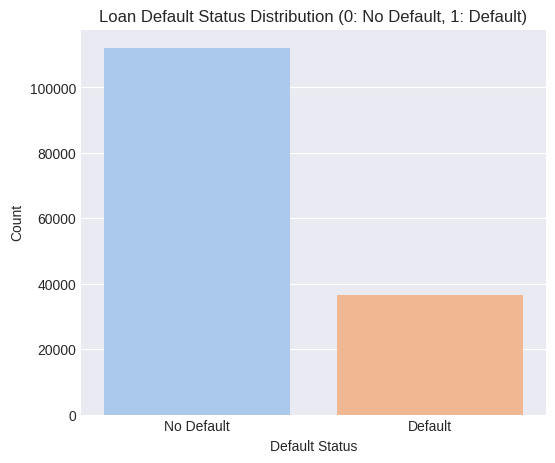

已显示目标变量 'Status' 的分布。


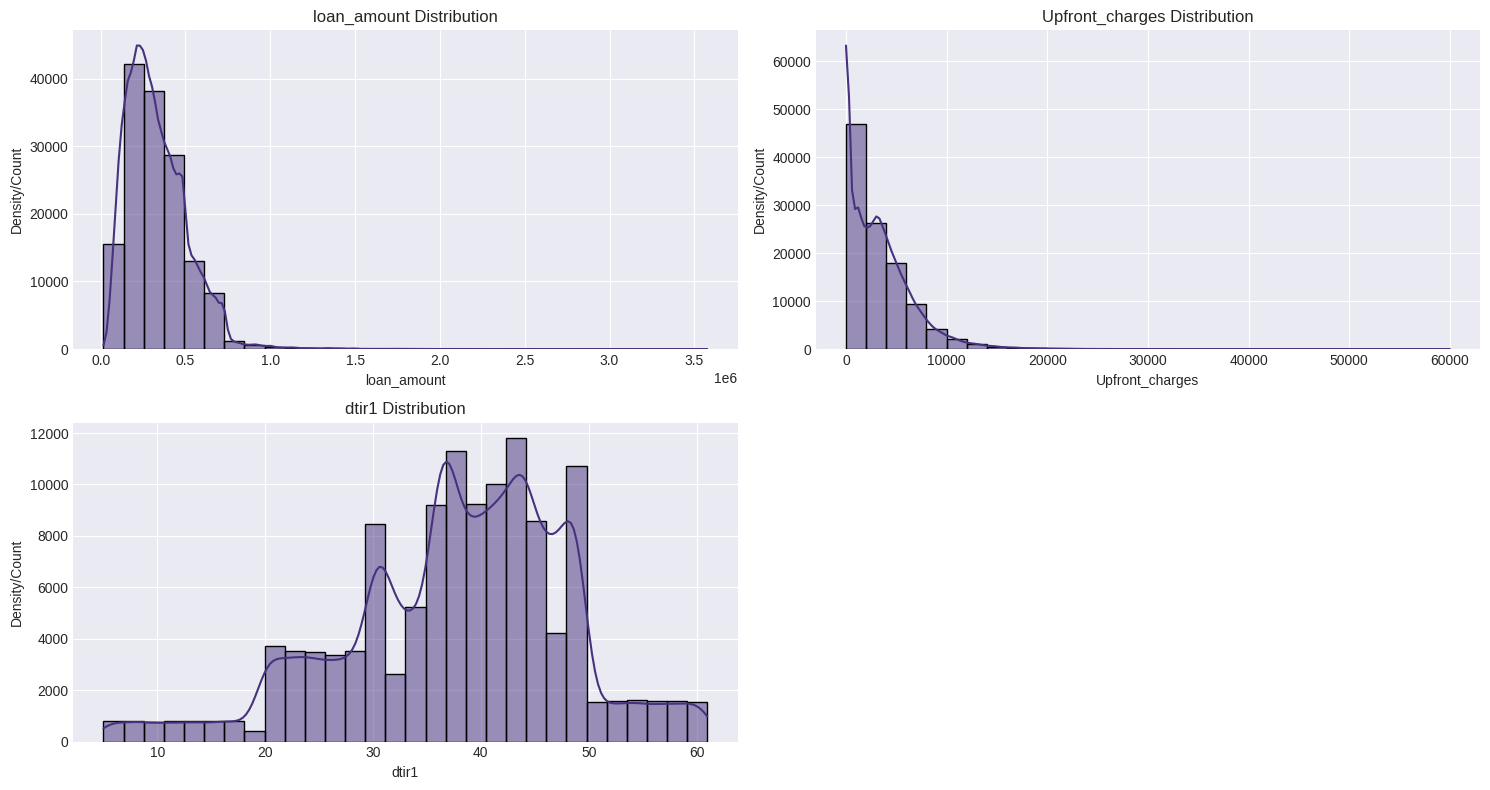

已显示部分数值特征的分布 (loan_amount, Upfront_charges, dtir1)。


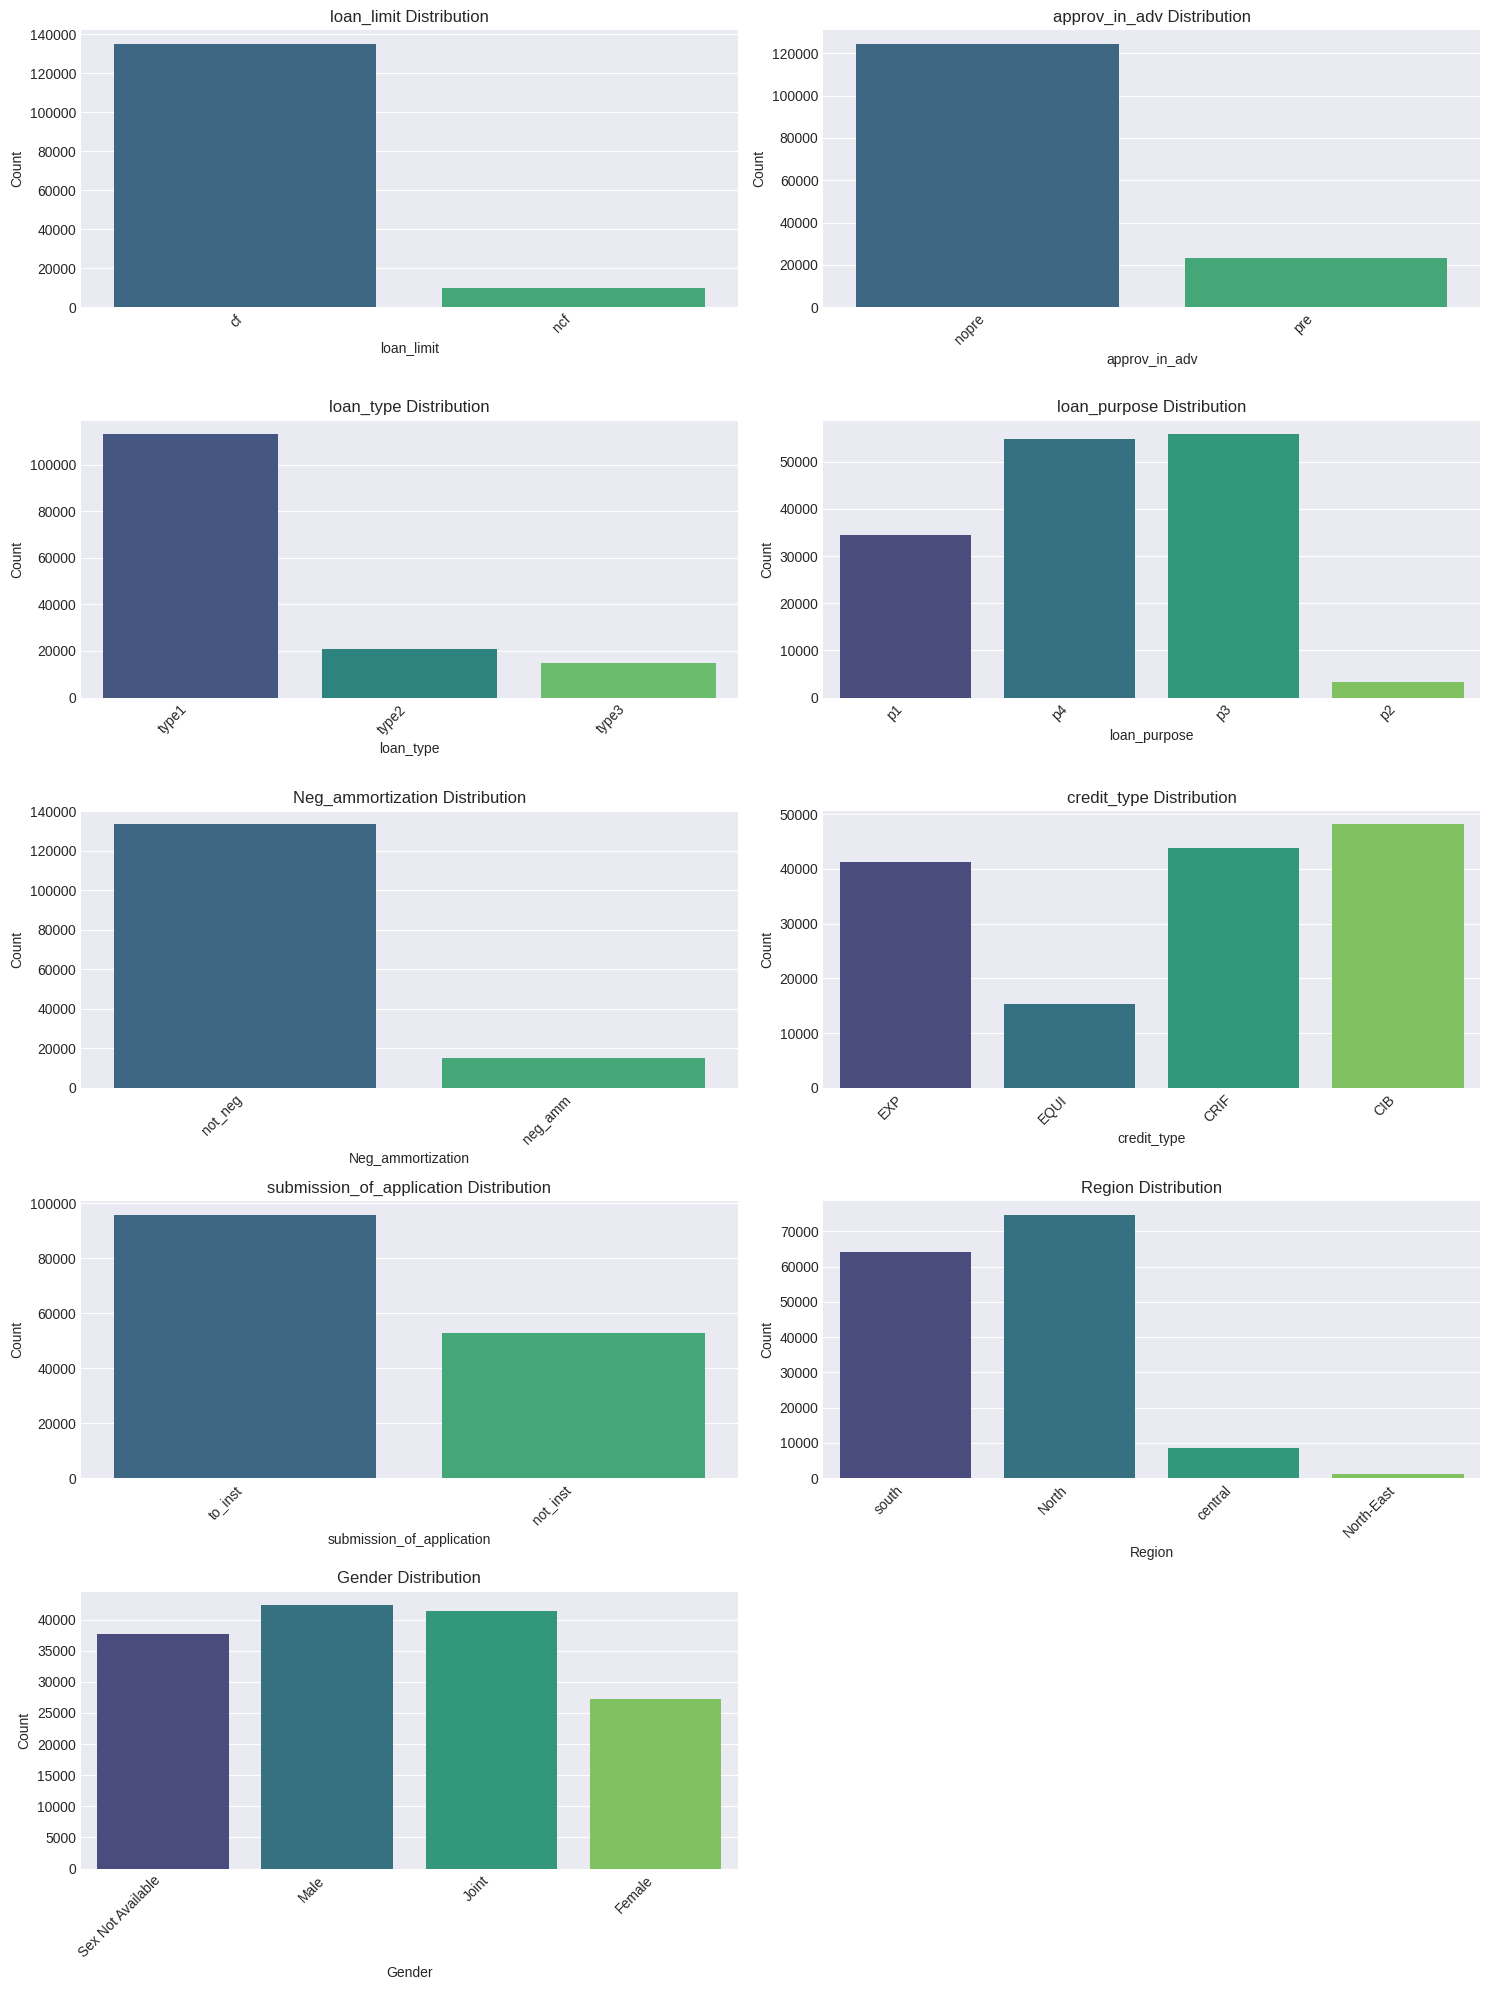

已显示部分编码后类别特征的分布 (loan_limit, approv_in_adv, loan_type, loan_purpose, Neg_ammortization, credit_type, submission_of_application, Region, Gender)。


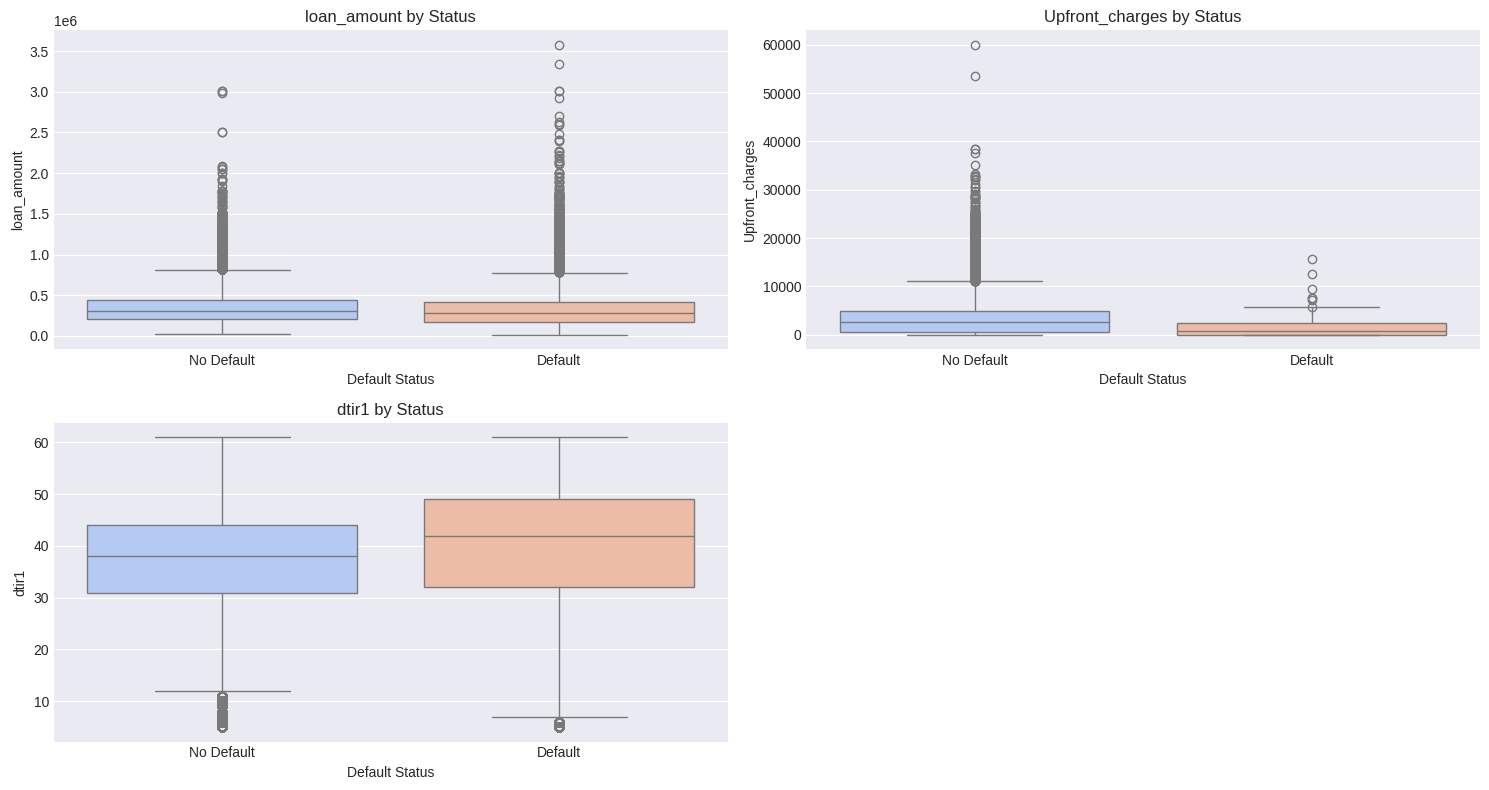

已显示部分数值特征与 'Status' 的关系。


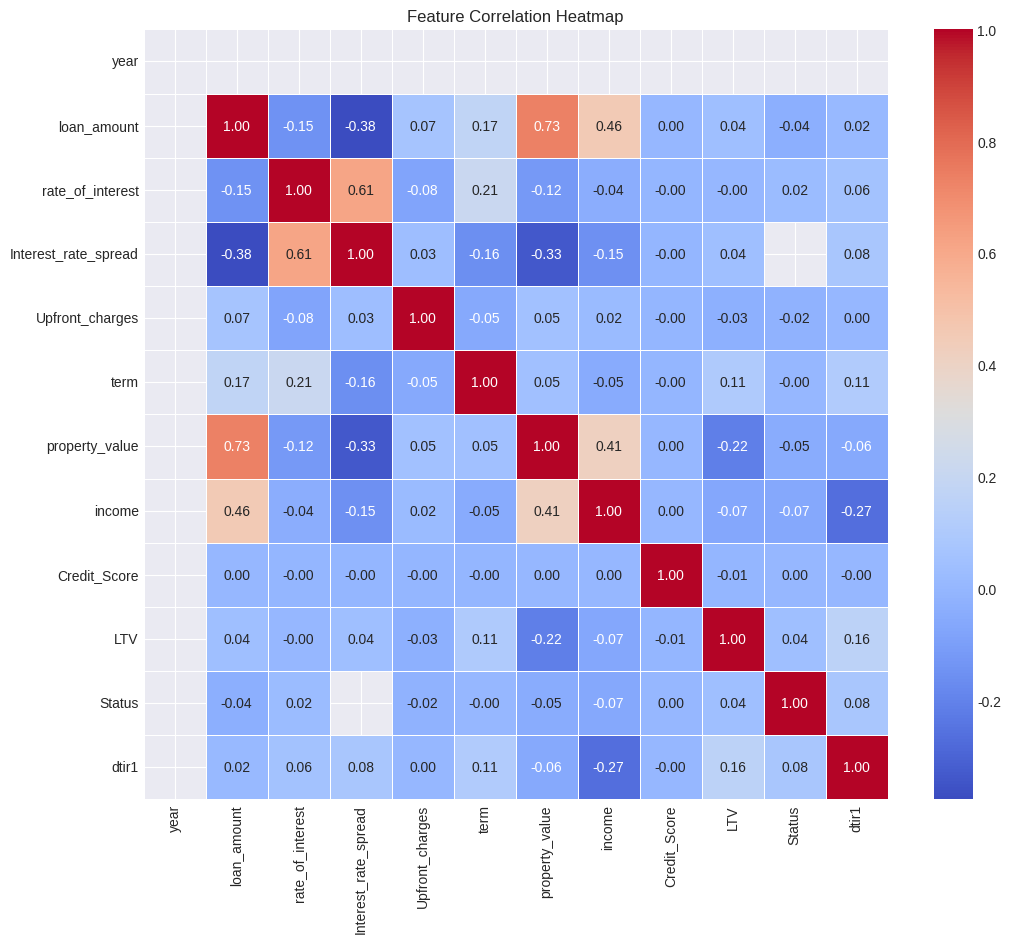

已显示特征相关性热力图。
--------------------------------------------------
------- 进入数据预处理函数 -------
开始填充缺失值...
处理缺失值后，行数保持不变: 148670 行。
在填充缺失值之后，'Status' 列的分布:
Status
0    112031
1     36639
Name: count, dtype: int64
--------------------------------------------------
处理重复值后，删除 0 行，剩余 148670 行。
在 drop_duplicates 之后，'Status' 列的分布:
Status
0    112031
1     36639
Name: count, dtype: int64
--------------------------------------------------
数据预处理完成。
所有预处理完成后，数据形状: (148670, 34)，'Status' 列的最终分布:
Status
0    112031
1     36639
Name: count, dtype: int64
--------------------------------------------------

训练集形状: (118936, 33), 测试集形状: (29734, 33)
训练集中 'Status' 分布:
Status
0    89625
1    29311
Name: count, dtype: int64
测试集中 'Status' 分布:
Status
0    22406
1     7328
Name: count, dtype: int64
--------------------------------------------------

随机森林模型训练完成。

------- 模型评估结果与可视化 -------
准确率 (Accuracy): 0.9999327369341494
精确率 (Precision): 1.0
召回率 (Recall): 0.9997270742358079
F1 分数 (F1-Score): 0.9998635184932442
AUC:

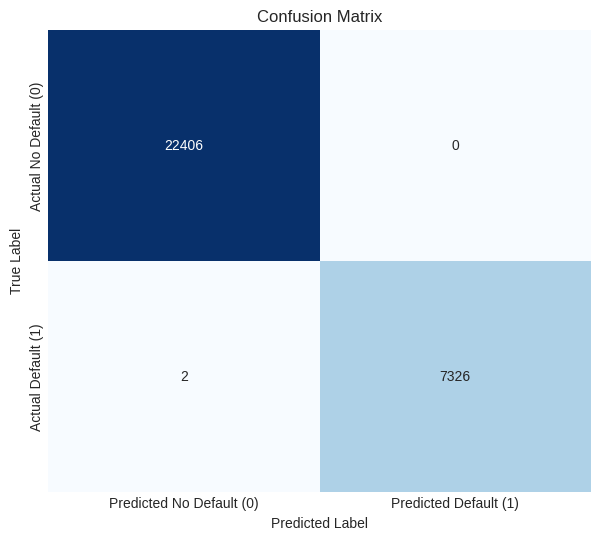

已显示混淆矩阵。


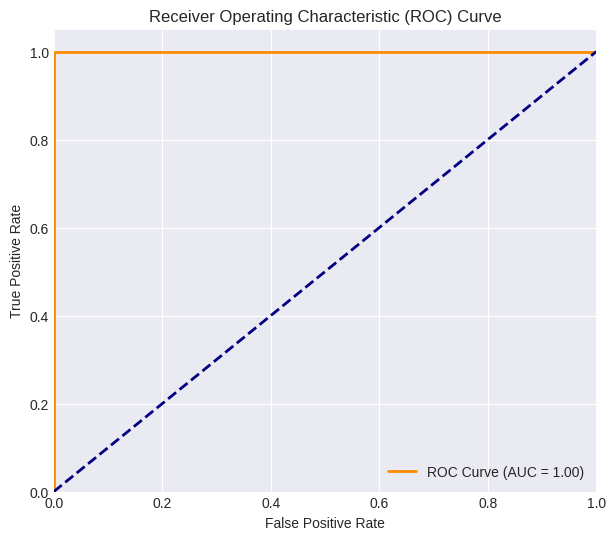

已显示 ROC 曲线。


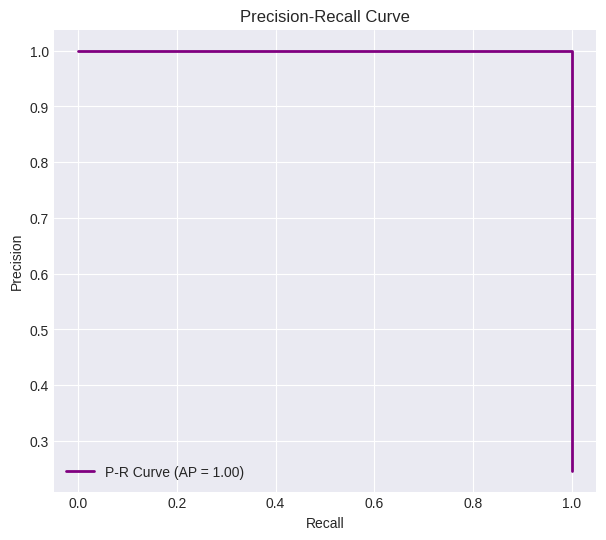

已显示精确率-召回率曲线。
--------------------------------------------------

------- 特征重要性可视化 -------


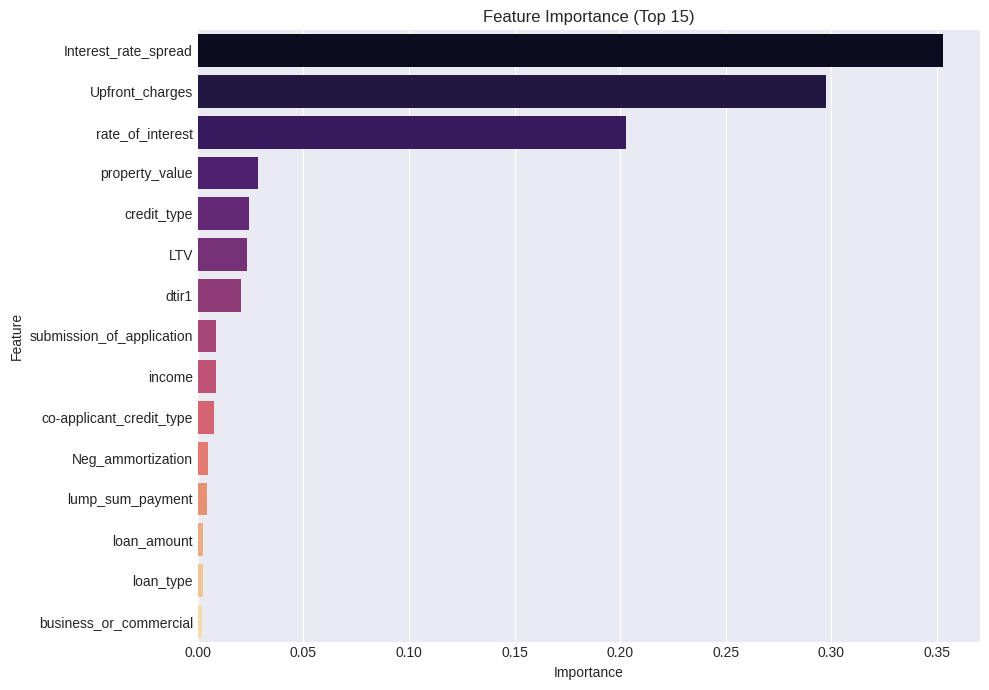

已显示前 15 个重要特征的条形图。
--------------------------------------------------


In [20]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, classification_report, confusion_matrix,
    roc_curve, precision_recall_curve, average_precision_score
)
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore') # 忽略警告信息

# --- Plotting style settings ---
# Reverted to English for plot titles/labels, so no Chinese font settings needed here.
try:
    plt.style.use('seaborn-v0_8-darkgrid')
except:
    plt.style.use('seaborn-darkgrid')

sns.set_palette('viridis') # 设置默认调色板
# --- End plotting style settings ---


# --- 数据加载和预处理 ---

def load_data(filepath):
    """加载数据集"""
    df = pd.read_csv(filepath)
    print(f"数据加载成功，原始形状: {df.shape}")
    print(f"原始数据中 'Status' 列的唯一值及其计数:\n{df['Status'].value_counts()}")
    print("-" * 50)
    return df

def preprocess_data(df):
    """数据预处理，包括缺失值处理、编码和标准化"""
    print("------- 进入数据预处理函数 -------")

    # 1. 缺失值处理：使用填充（中位数/众数）而不是删除行
    print("开始填充缺失值...")

    # 填充数值型列的缺失值（使用中位数）
    for col in df.select_dtypes(include=np.number).columns:
        if col != 'Status': # 不填充目标变量
            if df[col].isnull().any(): # 检查该列是否有缺失值
                median_val = df[col].median()
                df[col].fillna(median_val, inplace=True)

    # 填充对象（类别）型列的缺失值（使用众数）
    for col in df.select_dtypes(include='object').columns:
        if df[col].isnull().any(): # 检查该列是否有缺失值
            mode_val = df[col].mode()[0] # mode() 返回 Series，取第一个值
            df[col].fillna(mode_val, inplace=True)

    print(f"处理缺失值后，行数保持不变: {df.shape[0]} 行。")
    print(f"在填充缺失值之后，'Status' 列的分布:\n{df['Status'].value_counts()}")
    print("-" * 50)

    # 2. 重复值处理：删除完全重复的行
    initial_rows_before_duplicates = df.shape[0]
    df.drop_duplicates(inplace=True)
    rows_dropped_by_duplicates = initial_rows_before_duplicates - df.shape[0]
    print(f"处理重复值后，删除 {rows_dropped_by_duplicates} 行，剩余 {df.shape[0]} 行。")
    print(f"在 drop_duplicates 之后，'Status' 列的分布:\n{df['Status'].value_counts()}")

    # 检查 Status 是否仍包含至少两个类别
    if len(df['Status'].value_counts()) < 2:
        raise ValueError(
            "错误：在数据清洗和预处理后，目标变量 'Status' 列只包含一个类别。 "
            "这导致无法进行二分类预测。请检查您的数据源或数据清洗逻辑，"
            "确保至少有两个类别样本存在。"
        )
    print("-" * 50)

    # 3. 编码类别特征 (排除 'Status' 列)
    label_encoders = {}
    categorical_cols_to_encode = [col for col in df.select_dtypes(include=['object']).columns if col != 'Status']
    for col in categorical_cols_to_encode:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str)) # 确保转换为字符串再编码
        label_encoders[col] = le

    # 4. 标准化数值特征 (排除 'Status' 列)
    scaler = StandardScaler()
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if 'Status' in num_cols:
        num_cols.remove('Status') # 移除目标变量

    cols_to_scale = [col for col in num_cols if df[col].nunique() > 1]
    if cols_to_scale:
        df[cols_to_scale] = scaler.fit_transform(df[cols_to_scale])
    else:
        print("没有需要标准化的数值特征或所有数值特征都是常量。")

    print("数据预处理完成。")
    print(f"所有预处理完成后，数据形状: {df.shape}，'Status' 列的最终分布:\n{df['Status'].value_counts()}")
    print("-" * 50)
    return df, label_encoders, scaler


def train_model(X_train, y_train):
    """训练随机森林分类器"""
    model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, class_weight='balanced')
    model.fit(X_train, y_train)
    print("\n随机森林模型训练完成。")
    return model

# --- 可视化函数 ---

def plot_eda(df):
    """执行数据探索性分析可视化"""
    print("\n------- 数据探索性分析 (EDA) 可视化 -------")

    # 1. Target Variable Distribution
    plt.figure(figsize=(6, 5))
    sns.countplot(x='Status', data=df, palette='pastel')
    plt.title('Loan Default Status Distribution (0: No Default, 1: Default)')
    plt.xlabel('Default Status')
    plt.ylabel('Count')
    plt.xticks([0, 1], ['No Default', 'Default'])
    plt.show()
    print("已显示目标变量 'Status' 的分布。")

    # 2. Numerical Feature Distributions (Histograms/KDE)
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if 'Status' in numeric_cols:
        numeric_cols.remove('Status')

    cols_to_plot = [
        'loan_amount', 'interest_rate', 'Upfront_charges', 'Annual_Income',
        'credit_score', 'submission_LTV', 'dtir1', 'total_income', 'age'
    ]
    cols_to_plot = [col for col in cols_to_plot if col in numeric_cols]

    if cols_to_plot:
        num_plots = len(cols_to_plot)
        num_rows = (num_plots + 1) // 2
        plt.figure(figsize=(15, 4 * num_rows))
        for i, col in enumerate(cols_to_plot):
            plt.subplot(num_rows, 2, i + 1)
            sns.histplot(df[col], kde=True, bins=30)
            plt.title(f'{col} Distribution')
            plt.xlabel(col)
            plt.ylabel('Density/Count')
        plt.tight_layout()
        plt.show()
        print(f"已显示部分数值特征的分布 ({', '.join(cols_to_plot)})。")
    else:
        print("没有合适的数值特征进行分布可视化。")

    # 3. Categorical Feature Distributions (Bar Plots)
    encoded_categorical_cols = [
        'loan_limit', 'approv_in_adv', 'loan_type', 'loan_purpose',
        'Neg_ammortization', 'credit_type', 'submission_of_application', 'Region', 'Security_Status', 'Gender'
    ]
    encoded_categorical_cols = [col for col in encoded_categorical_cols if col in df.columns]

    if encoded_categorical_cols:
        num_plots = len(encoded_categorical_cols)
        num_rows = (num_plots + 1) // 2
        plt.figure(figsize=(15, 4 * num_rows))
        for i, col in enumerate(encoded_categorical_cols):
            plt.subplot(num_rows, 2, i + 1)
            sns.countplot(x=col, data=df, palette='viridis')
            plt.title(f'{col} Distribution')
            plt.xlabel(col)
            plt.ylabel('Count')
            plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
        print(f"已显示部分编码后类别特征的分布 ({', '.join(encoded_categorical_cols)})。")
    else:
        print("没有合适的编码后类别特征进行分布可视化。")

    # 4. Numerical Features vs. Target Variable (Box/Violin Plots)
    cols_to_plot_with_status = [
        'loan_amount', 'interest_rate', 'Upfront_charges', 'Annual_Income',
        'credit_score', 'submission_LTV', 'dtir1', 'total_income', 'age'
    ]
    cols_to_plot_with_status = [col for col in cols_to_plot_with_status if col in numeric_cols]

    if cols_to_plot_with_status:
        num_plots = len(cols_to_plot_with_status)
        num_rows = (num_plots + 1) // 2
        plt.figure(figsize=(15, 4 * num_rows))
        for i, col in enumerate(cols_to_plot_with_status):
            plt.subplot(num_rows, 2, i + 1)
            sns.boxplot(x='Status', y=col, data=df, palette='coolwarm')
            plt.title(f'{col} by Status')
            plt.xlabel('Default Status')
            plt.ylabel(col)
            plt.xticks([0, 1], ['No Default', 'Default'])
        plt.tight_layout()
        plt.show()
        print(f"已显示部分数值特征与 'Status' 的关系。")

    # 5. Feature Correlation Heatmap
    plt.figure(figsize=(12, 10))
    corr_df = df.select_dtypes(include=[np.number]).drop(columns=['ID'], errors='ignore')
    sns.heatmap(corr_df.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
    plt.title('Feature Correlation Heatmap')
    plt.show()
    print("已显示特征相关性热力图。")
    print("-" * 50)


def evaluate_model(model, X_test, y_test):
    """评估模型性能并可视化结果"""
    print("\n------- 模型评估结果与可视化 -------")
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] # 获取正类的概率

    print('准确率 (Accuracy):', accuracy_score(y_test, y_pred))
    print('精确率 (Precision):', precision_score(y_test, y_pred))
    print('召回率 (Recall):', recall_score(y_test, y_pred))
    print('F1 分数 (F1-Score):', f1_score(y_test, y_pred))
    print('AUC:', roc_auc_score(y_test, y_prob))
    print('\n详细分类报告:\n', classification_report(y_test, y_pred))

    # 1. Confusion Matrix Visualization
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(7, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Predicted No Default (0)', 'Predicted Default (1)'],
                yticklabels=['Actual No Default (0)', 'Actual Default (1)'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
    print("已显示混淆矩阵。")

    # 2. ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc_score = roc_auc_score(y_test, y_prob)
    plt.figure(figsize=(7, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {auc_score:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()
    print("已显示 ROC 曲线。")

    # 3. Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    ap_score = average_precision_score(y_test, y_prob)
    plt.figure(figsize=(7, 6))
    plt.plot(recall, precision, color='purple', lw=2, label=f'P-R Curve (AP = {ap_score:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")
    plt.grid(True)
    plt.show()
    print("已显示精确率-召回率曲线。")
    print("-" * 50)


def feature_importance_plot(model, feature_names, top_n=15):
    """可视化特征重要性"""
    print("\n------- 特征重要性可视化 -------")
    importances = model.feature_importances_
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': importances})
    feature_importances = feature_importances.sort_values(by='importance', ascending=False)

    plt.figure(figsize=(10, 7))
    sns.barplot(x='importance', y='feature', data=feature_importances.head(top_n), palette='magma')
    plt.title(f'Feature Importance (Top {top_n})')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()
    print(f"已显示前 {top_n} 个重要特征的条形图。")
    print("-" * 50)


def main():
    # 数据路径
    filepath = '/content/data_task2/Loan_Default.csv'
    df = load_data(filepath)

    # 数据探索性分析 (在预处理之前进行)
    plot_eda(df.copy()) # 传入副本，避免修改原始df

    # 预处理
    df_processed, label_encoders, scaler = preprocess_data(df.copy())

    # 特征与标签
    X = df_processed.drop('Status', axis=1)
    y = df_processed['Status']

    # 划分训练集和测试集
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    print(f"\n训练集形状: {X_train.shape}, 测试集形状: {X_test.shape}")
    print(f"训练集中 'Status' 分布:\n{y_train.value_counts()}")
    print(f"测试集中 'Status' 分布:\n{y_test.value_counts()}")
    print("-" * 50)

    # 训练模型
    model = train_model(X_train, y_train)

    # 评估模型并可视化
    evaluate_model(model, X_test, y_test)

    # 特征重要性可视化
    feature_importance_plot(model, X.columns.tolist())


if __name__ == '__main__':
    main()